Text(0.5, 1.0, 'by hour')

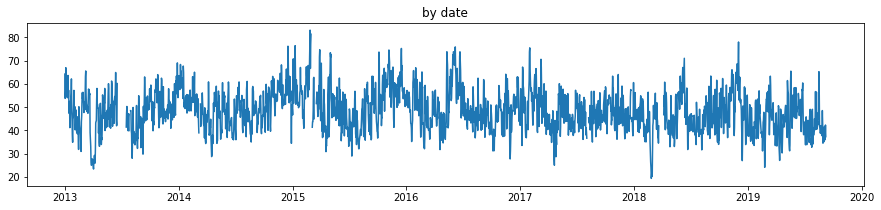

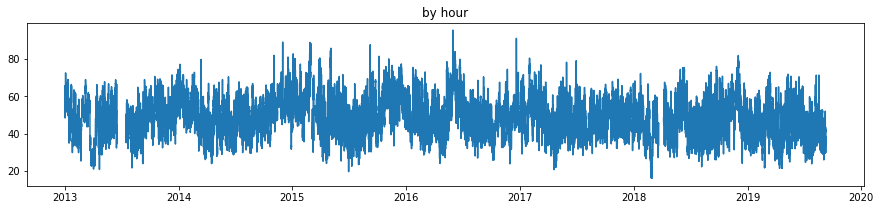

In [2]:
# load JSON
import json
import pandas as pd
 
# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-humidity.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
df_h = data

# group by date
data_d = data.groupby(['just_date'],squeeze=True).mean()
data_d.columns = ['_'.join(col).strip() for col in data_d.columns.values]
data_d = data_d.reset_index()
data_d.columns = ['ds','y'] # rename column
df_d = data_d

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
plt.figure(figsize=(15,3))
plt.plot(df_d['ds'],df_d['y'])
plt.title('by date')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


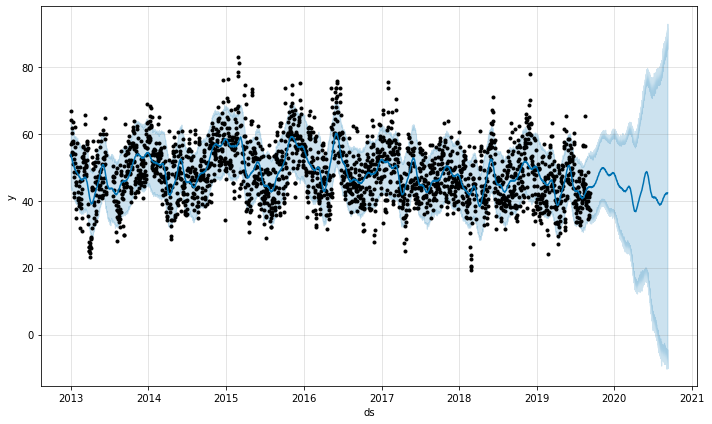

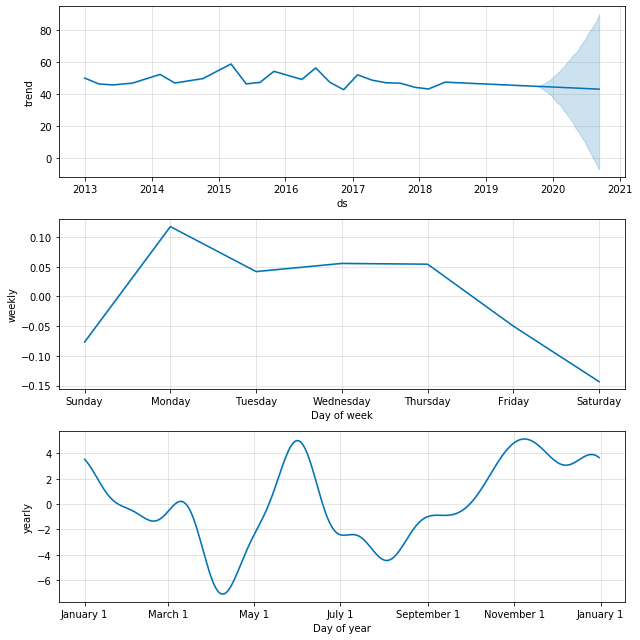

In [3]:
df = df_d # select daily or hourly daya

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=8760, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [4]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1000 days', period='100 days', horizon ='365 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2015-12-13 00:00:00 and 2018-09-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-12-14,59.480407,49.915555,67.924272,59.333333,2015-12-13
1,2015-12-15,59.476999,49.842240,68.063140,70.145833,2015-12-13
2,2015-12-16,59.687292,50.517703,68.333402,75.208333,2015-12-13
3,2015-12-17,59.977518,50.949124,69.345592,65.991667,2015-12-13
4,2015-12-18,60.398329,51.989606,70.266748,67.833333,2015-12-13


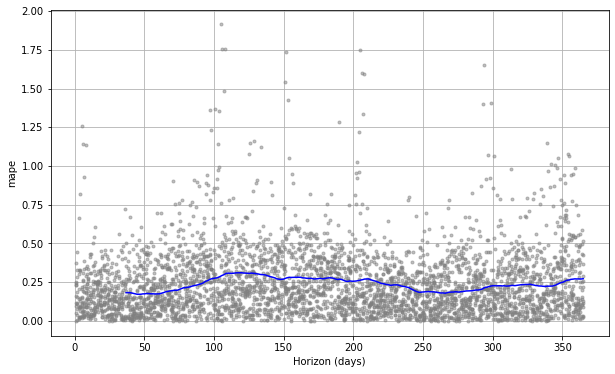

In [8]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [5]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 23.83095022852597%
SMAPE = 5.950700173814142%


In [6]:
import pickle
pkl_path = "franklin-d-roosevelt/humi_m.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# save the dataframe
forecast.to_pickle("franklin-d-roosevelt/humi_forecast.pkl")
print("*** Data Saved ***")

*** Data Saved ***


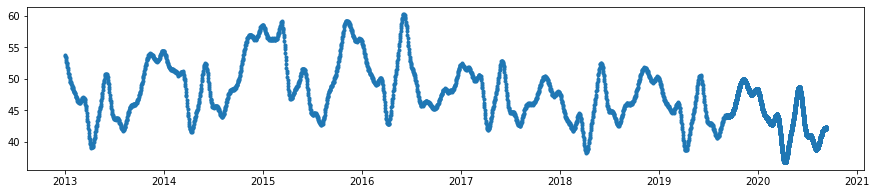

In [7]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
#plt.figure(figsize=(15,3))
#plt.plot(data_d.ds[50001:52160],data_d.y[50001:52160])